<a href="https://colab.research.google.com/github/barileao/SVM_Scania/blob/master/svm_scania_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando packages

In [1]:
!pip install pyod
!pip install impyute

     |████████████████████████████████| 92kB 2.7MB/s 
  Created wheel for pyod: filename=pyod-0.7.5-cp36-none-any.whl size=96597 sha256=62ff7ca8df90c56e3b1b8a36fc5c1ff1377fe54002b5e818d361d4a1f8c0b7a5
  Stored in directory: /root/.cache/pip/wheels/35/bc/f4/2cef321eac851ba02f533e3921b296bb4ce4998c8a4c9a8d6e
Successfully built pyod


# Imports

In [2]:
# importing all the necessary libraries
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from pyod.models.feature_bagging import FeatureBagging
from fancyimpute import SoftImpute
from impyute.imputation.cs import mice



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


# Upload dos dados


In [4]:
filetrain = r'/drive/My Drive/IFES/TCC_Scania/Codes/aps_failure_training_set.csv'
filetest = r'/drive/My Drive/IFES/TCC_Scania/Codes/aps_failure_test_set.csv'

train = pd.read_csv(filetrain)
print('Number of data points in the train dataset', train.shape[0])
print('Number of features in the given train dataset', train.shape[1])
test = pd.read_csv(filetest)
print('Number of data points in the test dataset', test.shape[0])
print('Number of features in the given test dataset', test.shape[1])

Number of data points in the train dataset 60000
Number of features in the given train dataset 171
Number of data points in the test dataset 16000
Number of features in the given test dataset 171


In [5]:
# ----------------------Train--------------------------------

# Replacing all the class labels as follows:

# neg = 0
# pos = 1
class_labels_train = []
for x in tqdm(train.index):        # tqdm = barra de progresso
    if train['class'].loc[x] == 'neg':
        class_labels_train.append(0)     
    else:
        class_labels_train.append(1)
     
train['class'] = class_labels_train

# Distrubution of class labels in train dataset
train['class'].value_counts()

# Teste
class_labels_test = []
for y in tqdm(test.index):        # tqdm = barra de progresso
    if test['class'].loc[y] == 'neg':
        class_labels_test.append(0)
    else:
        class_labels_test.append(1)

test['class'] = class_labels_test

# Distrubution of class labels in test dataset
test['class'].value_counts()



100%|██████████| 16000/16000 [00:00<00:00, 25313.49it/s]


0    15625
1      375
Name: class, dtype: int64

# Histograma

Percentage of negative class in the given dataset : 98.33333333333333
Percentage of positive class in the given dataset : 1.6666666666666667


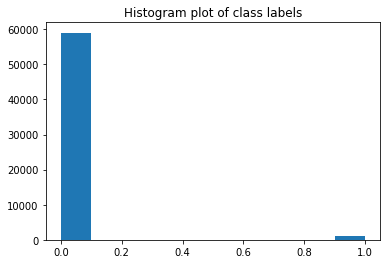

In [6]:
# Histogram plot of class labels of train dataset
plt.hist(train['class'])
plt.title("Histogram plot of class labels")
print("Percentage of negative class in the given dataset :", (train[train['class']== 0].shape[0] / train.shape[0]) * 100)
print("Percentage of positive class in the given dataset :", (train[train['class']== 1].shape[0] / train.shape[0]) * 100)


# Remover e substituir NAN e NA

In [7]:
# ----------------------Train--------------------------------
# Replacing the na and nan values with np.NaN
train.replace(to_replace='nan', value = np.NaN,inplace = True)
test.replace(to_replace='nan', value = np.NaN,inplace = True)

train.replace(to_replace = 'na', value = np.NaN, inplace = True)
test.replace(to_replace = 'na', value = np.NaN, inplace = True)

columns_names = train.columns

train.describe(include='all')
test.describe(include='all')

# Dropping all the columns where the number of missing values are more than 42K (>70%)
#train.dropna(axis = 1, thresh=42000,inplace= True)
#test.dropna(axis = 1, thresh=42000,inplace= True)
#train.head()
#test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,1.600000e+04,3637,15074,12019,15310,15310,15811,15811,15811,15811,15811,15811,15811,15811,15811,15811,15825,15837,15837,14802,15831,15837,15831,15838,15831,15838,15236,15837,15837,15837,15312,15312,15808,15808,15808,15808,15808,15808,15808,...,12282,12282,15312,15236,14906,14906,14906,14906,14906,14906,14906,14906,15810,15236,15236,15236,15236,15236,15236,15236,15236,15236,15236,15238,15238,14906,13356,13541,15808,15808,15808,15808,15808,15808,15808,15808,15808,15808,15238,15238
unique,NaN,NaN,18,1311,1202,170,201,59,221,800,2835,8647,13578,13400,10396,7335,2670,14139,1457,460,59,3809,4357,14862,14816,14474,12445,41,10,1368,19,2229,1287,153,287,295,310,549,6825,10694,...,89,10786,3722,1135,160,424,455,1890,26,80,59,69,8978,7981,5926,2743,2340,9678,7216,10010,10401,4419,2460,20,67,8698,10936,2360,13896,13233,11937,11038,11817,11915,10831,10271,8314,4042,12,24
top,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,NaN,NaN,2865,2289,519,14764,14741,15749,15575,14954,12442,340,499,326,4139,6684,10797,30,14200,12476,14698,9915,9857,32,33,28,45,14577,15828,14168,15819,2656,2720,15647,15502,15499,15484,15225,8039,4419,...,7315,276,219,222,14595,14451,13117,12184,14854,14822,14843,14836,34,3448,3325,11849,11810,655,631,839,836,10473,9604,15158,15013,5622,366,416,294,305,356,406,469,735,1151,2061,4500,8432,15167,15107
mean,0.023438,6.799698e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.151293,5.035350e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,9.280000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.098200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,4.947900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Train data: mediana, média e mais frequente 

In [8]:
# using median
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)

train_median = pd.DataFrame(impute_median.fit_transform(train),columns=train.columns)
train_median['class'].value_counts()

test_median = pd.DataFrame(impute_median.fit_transform(test),columns=test.columns)
test_median['class'].value_counts()
#train_imputed_median.to_csv("Train_imputed_median")

# using mean
#impute_mean = SimpleImputer(missing_values= np.nan, strategy='mean',copy = True, verbose= 2)
#train_mean = pd.DataFrame(impute_mean.fit_transform(train),columns=train.columns)
#train_imputed_mean.to_csv("Train_imputed_mean")

# using most frequent
#impute_most_frequent = SimpleImputer(missing_values= np.nan, strategy='most_frequent',copy = True, verbose= 2)
#train_most_frequent = pd.DataFrame(impute_most_frequent.fit_transform(train),columns=train.columns)
#train_imputed_most_frequent.to_csv("Train_imputed_most_frequent")

# Feature engineering, creating a new feature set which indicates 
# the missing value in a given row and column as True else False
#missing_impute = MissingIndicator()
#miss = missing_impute.fit_transform(train)
#train_miss_indi = pd.DataFrame(miss)
#train_miss_indi.to_csv('train_miss_indi.csv')

0.0    15625
1.0      375
Name: class, dtype: int64

# Retirar os Outliers para o treinamento

In [9]:
#coletando os outliers do train para 'trainol'
trainol_median = train_median.loc[(train_median['class'] ==1)]
testol_median = test_median.loc[(test_median['class'] ==1)]
#print(trainol_median)

#removendo os outliers para treinamento 
train_median = train_median[train_median['class'] != 1]
print(train_median)
train_median['class'].value_counts()

#removendo os outliers para teste
test_median = test_median[test_median['class'] != 1]
print(test_median)
test_median['class'].value_counts()

       class    aa_000  ab_000  ...    ee_009  ef_000  eg_000
0        0.0   76698.0     0.0  ...       0.0     0.0     0.0
1        0.0   33058.0     0.0  ...    1500.0     0.0     0.0
2        0.0   41040.0     0.0  ...     514.0     0.0     0.0
3        0.0      12.0     0.0  ...       0.0     4.0    32.0
4        0.0   60874.0     0.0  ...    1218.0     0.0     0.0
...      ...       ...     ...  ...       ...     ...     ...
59995    0.0  153002.0     0.0  ...   28588.0     0.0     0.0
59996    0.0    2286.0     0.0  ...       0.0     0.0     0.0
59997    0.0     112.0     0.0  ...       0.0     0.0     0.0
59998    0.0   80292.0     0.0  ...  388422.0     0.0     0.0
59999    0.0   40222.0     0.0  ...     158.0     0.0     0.0

[59000 rows x 171 columns]
       class   aa_000  ab_000        ac_000  ...    ee_008   ee_009  ef_000  eg_000
0        0.0     60.0     0.0  2.000000e+01  ...       0.0      0.0     0.0     0.0
1        0.0     82.0     0.0  6.800000e+01  ...       0.0  

0.0    15625
Name: class, dtype: int64

# Padronizando os dados

In [0]:
# Get column names first
names = train.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler().fit(train_median)

# Fit your data on the scaler object - train_imputed_median
train_median = scaler.fit_transform(train_median)
train_median = pd.DataFrame(train_median, columns=names)
trainol_median = scaler.fit_transform(trainol_median)
trainol_median = pd.DataFrame(trainol_median, columns=names)

# Fit your data on the scaler object - test_imputed_median
test_median = scaler.fit_transform(test_median)
test_median = pd.DataFrame(test_median, columns=names)
testol_median = scaler.fit_transform(testol_median)
testol_median = pd.DataFrame(testol_median, columns=names)

# Fit your data on the scaler object - train_imputed_mean
#train_mean = scaler.fit_transform(train_mean)
#train_mean = pd.DataFrame(train_mean, columns=names)

# Fit your data on the scaler object - train_imputed_most_frequent
#train_most_frequent = scaler.fit_transform(train_most_frequent)
#train_most_frequent = pd.DataFrame(train_most_frequent, columns=names)


# Retirar a coluna ['class'] do train e trainol

In [0]:
train_median = train_median.drop(['class'], axis =1)
trainol_median = trainol_median.drop(['class'], axis =1)
test_median = test_median.drop(['class'], axis =1)
testol_median = testol_median.drop(['class'], axis =1)

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=80)
pca.fit(train_median)

train_median_pca = pca.transform(train_median)
train_median_pca = pd.DataFrame(train_median_pca)
trainol_median_pca = pca.transform(trainol_median)
trainol_median_pca = pd.DataFrame(trainol_median_pca)

test_median_pca = pca.transform(test_median)
test_median_pca = pd.DataFrame(test_median_pca)
testol_median_pca = pca.transform(testol_median)
trainol_median_pca = pd.DataFrame(testol_median_pca)

print(pca.explained_variance_)

[48.78657839  8.18804388  7.2015321   6.03842721  5.41748975  4.14388999
  3.00017091  2.84799187  2.6418999   2.49203155  2.35613668  2.19720208
  2.10186187  2.0098764   1.87689694  1.84944744  1.81515726  1.74247439
  1.71148736  1.65757902  1.56016302  1.5334561   1.45126535  1.40206285
  1.38628863  1.36107636  1.30538849  1.25363302  1.24516383  1.22331252
  1.20527623  1.16352291  1.14689424  1.109084    1.07934913  1.05695342
  1.05575416  1.01109635  1.00525236  1.00177838  0.99275718  0.98022116
  0.96222451  0.94751667  0.93880661  0.89552813  0.87004743  0.83581147
  0.82404109  0.809494    0.79846654  0.7751482   0.75584713  0.74628703
  0.73133511  0.70224897  0.6878337   0.6739576   0.65848759  0.64006294
  0.63825759  0.59751971  0.59394212  0.59080507  0.57836371  0.55540419
  0.53935608  0.52060241  0.51493524  0.50657098  0.48160134  0.46937596
  0.45102777  0.43964324  0.42744128  0.3921535   0.38512958  0.37074155
  0.35974756  0.34386118]


In [26]:
print(pca.n_components)

0.8


# Training: One-Class SVM

In [22]:
oneclass = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05, tol=0.0001, verbose=True)

#oneclass.fit(train_median)
oneclass.fit(train_median_pca)
#oneclass.fit(train_mean)
#oneclass.fit(train_most_frequent)

[LibSVM]

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.0001,
            verbose=True)

# Salvar arquivo com Pickle

In [0]:
import pickle

# salvar arquivo de treino
filename = '/drive/My Drive/IFES/TCC_Scania/Redes treinadas/modelpca_median_nu_01_tol_1e4_3.sav'
pickle.dump(oneclass, open(filename, 'wb'))


In [0]:
#import pickle

# carregar arquivo de treino
oneclass = pickle.load(open('/drive/My Drive/IFES/TCC_Scania/Redes treinadas/modelpca_median_nu_003_tol_1e4_1.sav', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

# Predict

In [0]:
# tirado de: https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html

#y_pred_train = loaded_model.predict(train_median)
#y_pred_outliers_val = loaded_model.predict(trainol_median)
#n_error_train = y_pred_train[y_pred_train == -1].size
#n_error_outliers_val = y_pred_outliers_val[y_pred_outliers_val == 1].size
#print('erro treino = ', n_error_train)
#print('erro outliers validacao = ', n_error_outliers_val)

#y_pred_test = loaded_model.predict(test_median)
#y_pred_outliers_test = loaded_model.predict(testol_median)
#n_error_test = y_pred_test[y_pred_test == -1].size
#n_error_outliers_test = y_pred_outliers_test[y_pred_outliers_test == 1].size
#print('erro teste = ', n_error_test)
#print('erro outliers teste = ', n_error_outliers_test)

y_pred_train = loaded_model.predict(train_median_pca)
y_pred_outliers_val = loaded_model.predict(trainol_median_pca)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_outliers_val = y_pred_outliers_val[y_pred_outliers_val == 1].size
print('erro treino = ', n_error_train)
print('erro outliers validacao = ', n_error_outliers_val)

y_pred_test = loaded_model.predict(test_median_pca)
y_pred_outliers_test = loaded_model.predict(testol_median_pca)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers_test = y_pred_outliers_test[y_pred_outliers_test == 1].size
print('erro teste = ', n_error_test)
print('erro outliers teste = ', n_error_outliers_test)



In [31]:
y_pred_train = oneclass.predict(train_median_pca)
y_pred_outliers_val = oneclass.predict(trainol_median_pca)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_outliers_val = y_pred_outliers_val[y_pred_outliers_val == 1].size
print('erro treino = ', n_error_train)
print('erro outliers validacao = ', n_error_outliers_val)

y_pred_test = oneclass.predict(test_median_pca)
y_pred_outliers_test = oneclass.predict(testol_median_pca)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers_test = y_pred_outliers_test[y_pred_outliers_test == 1].size
print('erro teste = ', n_error_test)
print('erro outliers teste = ', n_error_outliers_test)

erro treino =  6662
erro outliers validacao =  0
erro teste =  2423
erro outliers teste =  0
